[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scardonac/income_prediction/blob/main/notebooks/income_prediction.ipynb)

# Predicción de ingresos en tienda mobiliaria

Este proyecto busca predecir los ingresos de una tienda de mobiliario mediante técnicas avanzadas de aprendizaje automático. Se emplean herramientas como Pandas, Matplotlib, Seaborn, XGBoost, LightGBM y Optuna para construir modelos predictivos robustos, aprovechando patrones históricos y variables contextuales. Se pretende mejorar el rendimiento y la competitividad de la tienda en el mercado mediante un flujo de trabajo integral de aprendizaje automático que brinde insights significativos.

# Importando librerías

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import holidays
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

import xgboost as xgb
import lightgbm as lgb
from optuna import create_study
from optuna.trial import Trial
from typing import Any
import mlflow
from sklearn.metrics import mean_squared_error
from pathlib import Path
import pickle

# Silence warnings
warnings.filterwarnings('ignore')

c:\Users\SaraCardonaCarrillo_\miniconda3\envs\demand\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargando datos

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/scardonac/income_prediction/main/data/revenues.csv")
catalog_df = pd.read_csv("https://raw.githubusercontent.com/scardonac/income_prediction/main/data/catalog.csv",sep=";",  encoding='latin-1')
print(data.head())
print(catalog_df.head())

         date product_id  total_amt
0  2019-01-01   438b7061    4739.24
1  2019-01-01   cff49f0b    2296.55
2  2019-01-01   51fefc12     917.03
3  2019-01-01   25889643     495.49
4  2019-01-01   d6f5a85d    2107.92
  product_id          category    size  premium  exclusive  seasonal
0   438b7061            sillas  medium      0.0          1         0
1   cff49f0b  mesitas_de_noche   small      NaN          0         0
2   51fefc12            sillas   small      0.0          1         0
3   25889643           cómodas   small      0.0          1         1
4   d6f5a85d          lamparas   small      0.0          1         0


In [ ]:
print(catalog_df.info())
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  135 non-null    object 
 1   category    135 non-null    object 
 2   size        132 non-null    object 
 3   premium     130 non-null    float64
 4   exclusive   135 non-null    int64  
 5   seasonal    135 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 6.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126460 entries, 0 to 126459
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        126460 non-null  object 
 1   product_id  126460 non-null  object 
 2   total_amt   126460 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.9+ MB
None


In [ ]:
print(data.describe())

           total_amt
count  126460.000000
mean     1594.293532
std       998.590787
min        18.320000
25%       836.242500
50%      1438.420000
75%      2175.637500
max      8965.950000


Se puede observar que el dataset de catálogo de productos tiene datos faltantes en las variables **size** y **premium**. Vamos a realizar la imputación de los datos solo en las variables usando *KNN Imputer*.

## Imputación para dataset catalogo

In [ ]:
def imputar_valores_nulos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputa la variable "size" y "premium" utilizando KNN y convierte los valores a sus valores originales.

    Parámetros:
        df (pd.DataFrame): DataFrame de Pandas que contiene las variables "size" y "premium".

    Devuelve:
        pd.DataFrame: DataFrame de Pandas con las variables imputadas y convertidas.
    """

    # Crear copia del DataFrame para preservar los valores originales
    df_copy = df.copy()

    # Diccionario para mapear valores de string a números
    tamano_mapping = {"small": 1, "medium": 2, "large": 3}

    # Reemplazar valores de string por números
    df_copy["size_comp"] = df_copy["size"].replace(tamano_mapping)

    # Seleccionar variables con NaN
    variables_con_nan = ["size_comp", "premium"]

    # Imputación por KNN
    imputer = KNNImputer(n_neighbors=5)
    df_copy[variables_con_nan] = imputer.fit_transform(df_copy[variables_con_nan])

    # Convertir los valores imputados a etiquetas originales
    df_copy["size"] = df_copy["size_comp"].round().astype(int).replace({v: k for k, v in tamano_mapping.items()})

    # Redondear valores de "premium" a 0 o 1
    df_copy["premium"] = df_copy["premium"].round().astype(int)

    # Eliminar la variable "tamaño_comp" numérica
    df_copy.drop("size_comp", axis=1, inplace=True)

    return df_copy

catalog_df_transf = imputar_valores_nulos(catalog_df)
print(catalog_df_transf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  135 non-null    object
 1   category    135 non-null    object
 2   size        135 non-null    object
 3   premium     135 non-null    int32 
 4   exclusive   135 non-null    int64 
 5   seasonal    135 non-null    int64 
dtypes: int32(1), int64(2), object(3)
memory usage: 5.9+ KB
None


Se imputaron correctamente los datos faltantes en las variables **tamaño** y **premium**.

## Supuestos sobre los datos

Se asume que los datos son de Colombia

## Adicionar variables exógenas al dataset demanda: días festivos, IPC y tasa desempleo mensual en Colombia

Leyendo variables exógenas: IPC y tasa de desempleo

In [ ]:
ipc_df = pd.read_csv("https://raw.githubusercontent.com/scardonac/income_prediction/main/data/IPC.csv", sep=";",  encoding='latin-1')
des_df = pd.read_csv("https://raw.githubusercontent.com/scardonac/income_prediction/main/data/tasa_desempleo.csv", encoding='latin-1', sep=";")

Creando función para preparar los datos:

- Crea variables temporales asociadas a la fecha
- Crea la variable festivos
- Agrega los índices económicos por mes
- Se realiza el merge entre los datos de demanda y catálogo de productos

In [ ]:
def create_time_features(demand_df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea características de tiempo a partir de la columna 'date' en el DataFrame.

    Parámetros:
        demand_df (pd.DataFrame): DataFrame de Pandas que contiene la columna 'date'.

    Devuelve:
        pd.DataFrame: DataFrame de Pandas con las características de tiempo agregadas.
    """
    demand_df['date'] = pd.to_datetime(demand_df['date'])
    demand_df['year'] = demand_df['date'].dt.year
    demand_df['month'] = demand_df['date'].dt.month
    demand_df['day_of_week'] = demand_df['date'].dt.day_of_week
    return demand_df

def add_holidays_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega una columna 'holidays' al DataFrame df indicando si la fecha es un día festivo en Colombia.

    Parámetros:
        df (pd.DataFrame): DataFrame de Pandas que contiene la columna 'date'.

    Devuelve:
        pd.DataFrame: DataFrame de Pandas con la columna 'festivos' agregada.
    """
    colombia_holidays = holidays.Colombia()
    df['holidays'] = df['date'].apply(lambda x: 1 if x in colombia_holidays else 0)
    return df

def add_economic_indices(demand_df: pd.DataFrame, ipc_data: pd.DataFrame, des_data: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega datos económicos a partir de ipc_data y des_data al DataFrame demand_df.

    Parámetros:
        demand_df (pd.DataFrame): DataFrame de Pandas que contiene la columna 'date'.
        ipc_data (pd.DataFrame): DataFrame de Pandas que contiene datos de IPC.
        des_data (pd.DataFrame): DataFrame de Pandas que contiene datos de desempleo.

    Devuelve:
        pd.DataFrame: DataFrame de Pandas con los datos económicos agregados.
    """
    ipc_df = ipc_data.copy()
    des_df = des_data.copy()
    demand_df['Año Mes'] = demand_df['date'].dt.strftime('%Y-%m')
    ipc_df['Mes Año'] = pd.to_datetime(ipc_df['Mes Año'], format='%Y%m').dt.strftime('%Y-%m')
    df_merged = pd.merge(demand_df, ipc_df, left_on='Año Mes', right_on='Mes Año', how='left')
    df_merged = pd.merge(df_merged, des_df, left_on='Año Mes', right_on='Año-Mes (AAAA-MM)', how='left')
    df_merged.drop(['Mes Año', 'Año-Mes (AAAA-MM)', 'Variación anual %', 'Variación mensual %',
                    'Variación año corrido %', 'Año Mes'], axis=1, inplace=True)
    df_merged.replace(',', '.', regex=True, inplace=True)
    for col in ['Indice', 'Tasa de desempleo (%)', 'Tasa de ocupación (%)']:
        df_merged[col] = pd.to_numeric(df_merged[col])
    return df_merged


def merge_dataframes(catalog_df: pd.DataFrame, demand_df_eco: pd.DataFrame) -> pd.DataFrame:
    """
    Une los DataFrames catalog_df y demand_df_eco en base a la columna 'id_producto'.

    Parámetros:
        catalog_df (pd.DataFrame): DataFrame de Pandas a unir.
        demand_df_eco (pd.DataFrame): DataFrame de Pandas a unir.

    Devuelve:
        pd.DataFrame: DataFrame de Pandas resultante de la unión.
    """
    merged_df = pd.merge(catalog_df, demand_df_eco, on='product_id', how='inner')
    merged_df["premium"] = merged_df["premium"].astype("int")
    return merged_df

def prepare_data(demand_df: pd.DataFrame, ipc_df: pd.DataFrame, des_df: pd.DataFrame, catalog_df: pd.DataFrame) -> tuple:
    """
    Prepara los datos aplicando varias funciones a los DataFrames demand_df, ipc_df, des_df y catalog_df.

    Parámetros:
        demand_df (pd.DataFrame): DataFrame de Pandas principal.
        ipc_df (pd.DataFrame): DataFrame de Pandas con datos de IPC.
        des_df (pd.DataFrame): DataFrame de Pandas con datos de desempleo.
        catalog_df (pd.DataFrame): DataFrame de Pandas con información de catálogo.

    Devuelve:
        tuple: Un tuple con dos elementos: el DataFrame preparado y el DataFrame demand_df_eco.
    """
    demand_df = create_time_features(demand_df)
    demand_df = add_holidays_column(demand_df)
    demand_df_eco = add_economic_indices(demand_df, ipc_df, des_df)
    merged_df = merge_dataframes(catalog_df, demand_df_eco)
    return merged_df, demand_df_eco

In [ ]:
merged_df, demand_df_eco = prepare_data(data, ipc_df, des_df, catalog_df_transf)

# Análisis descriptivo

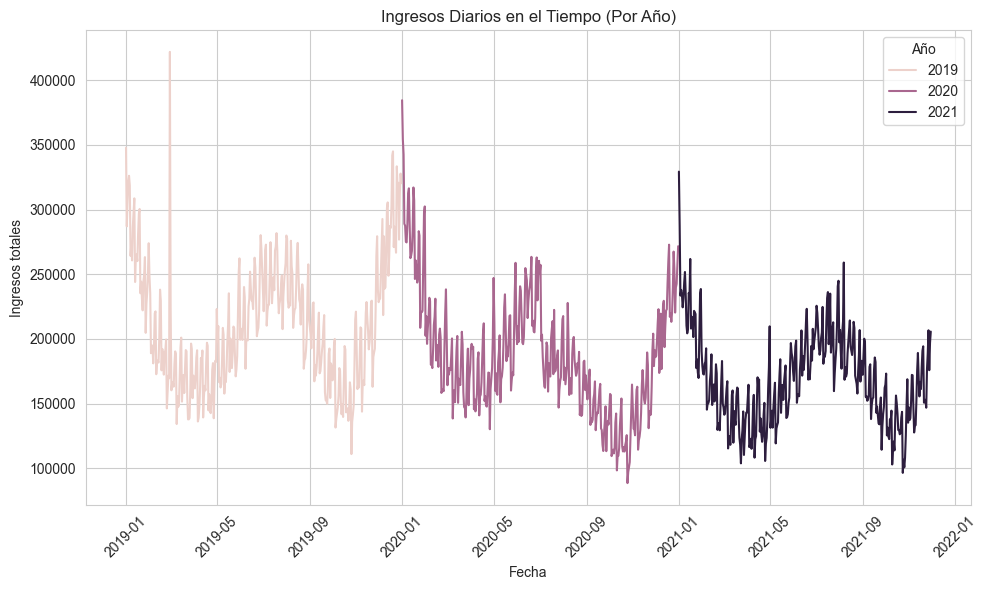

In [ ]:
# Agrupar por fecha y calcular los ingresos diarios
daily_demand = demand_df_eco.groupby(['date', 'year'])['total_amt'].sum().reset_index()

# Configurar el estilo de Seaborn
sns.set_style('whitegrid')

# Graficar los ingresos en el tiempo diferenciando por año con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='total_amt', hue='year', data=daily_demand)
plt.title('Ingresos Diarios en el Tiempo (Por Año)')
plt.xlabel('Fecha')
plt.ylabel('Ingresos totales')
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.tight_layout()
plt.show()

El gráfico muestra el comportamiento de los ingresos diaria por año. Se puede evidenciar un patrón estacional ya que durante el año se presentan picos de ingresos en enero, mitad de año y diciembre, y el patrón se repite cad año. También se puede evidenciar una tendencia a la baja en  ingresos ya que a medida que pasa el tiempo, los ingresos van disminuyendo.

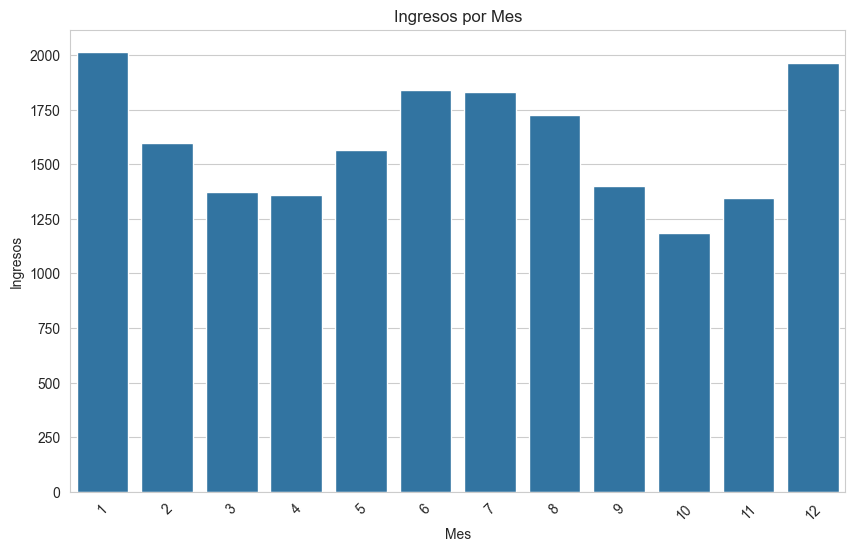

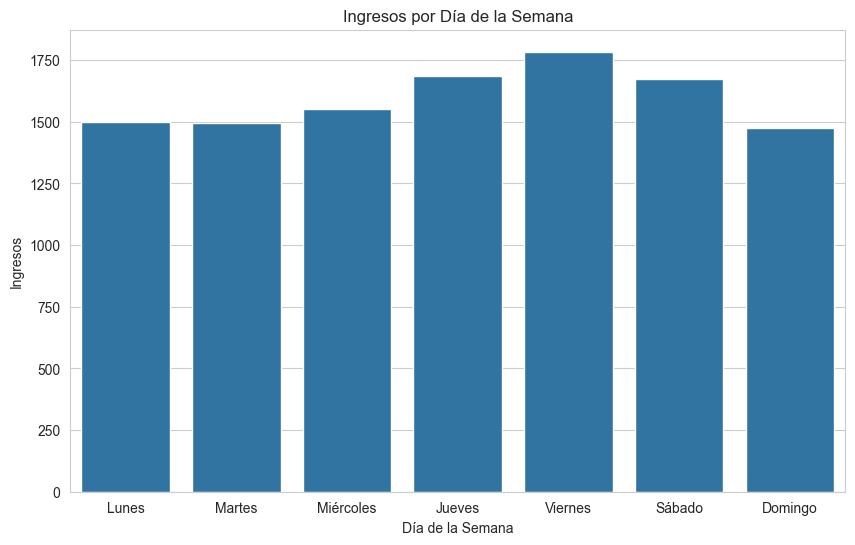

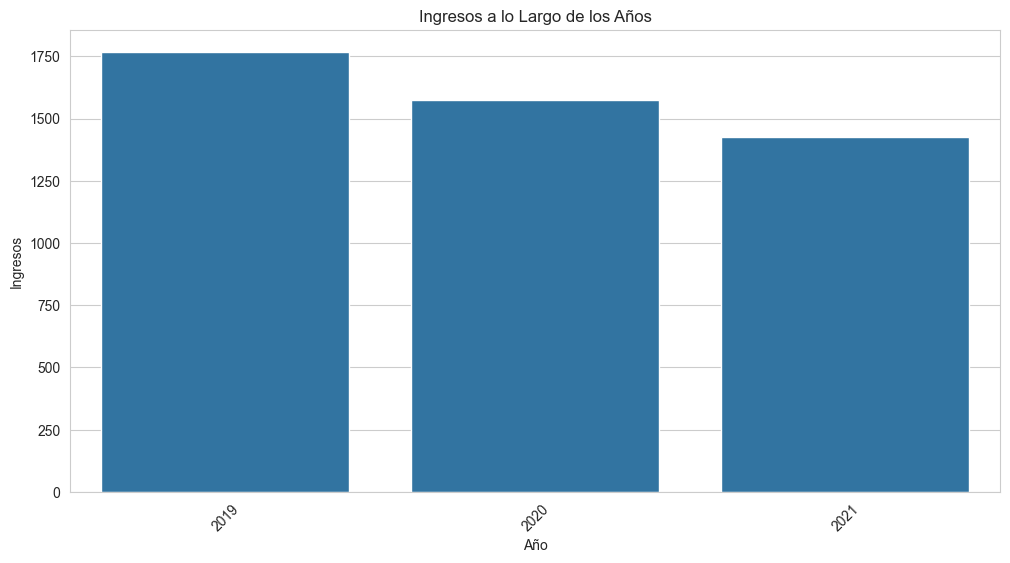

In [ ]:
# Gráfico de barras para ingresos por mes
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_amt', data=demand_df_eco, ci=None)
plt.title('Ingresos por Mes')
plt.xlabel('Mes')
plt.ylabel('Ingresos')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para ingresos por día de la semana
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='total_amt', data=demand_df_eco, ci=None)
plt.title('Ingresos por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Ingresos')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.show()

# Gráfico de línea para ingresos a lo largo de los años
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='total_amt', data=demand_df_eco, ci=None)
plt.title('Ingresos a lo Largo de los Años')
plt.xlabel('Año')
plt.ylabel('Ingresos')
plt.xticks(rotation=45)
plt.show()

En los gráficos anteriores se busca ver si hay alguna diferencia entre los ingresos y variables temporales. En el primer gráfico se observa la relación de los ingresos en cada mes. Como se mencionó anteriormente, los ingresos son más altos en general, en los meses enero y diciembre, y en mitad de año también se presentan ingresos altos. En el segundo gráfico, se evidencia que los días jueves, viernes y sábados hay una mayores ingresos. Finalmente, en el tercer gráfico, se evidencia que los ingresos han disminuido al pasar los años.

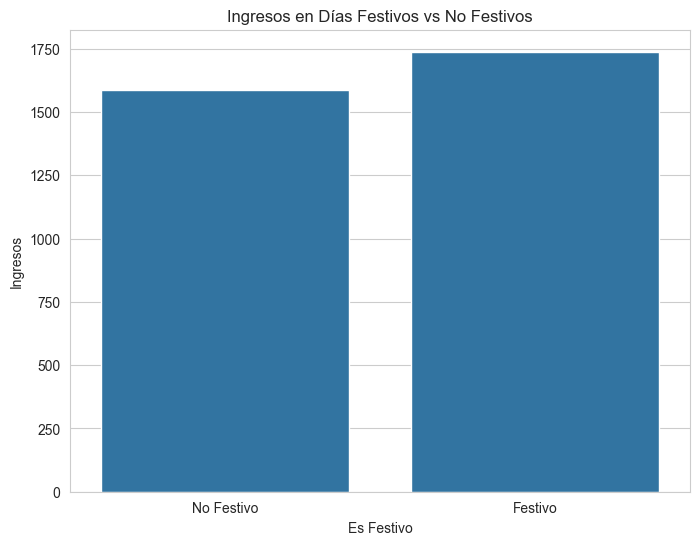

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='holidays', y='total_amt', data=merged_df, ci=None)
plt.title('Ingresos en Días Festivos vs No Festivos')
plt.xlabel('Es Festivo')
plt.ylabel('Ingresos')
plt.xticks(ticks=[0, 1], labels=['No Festivo', 'Festivo'])
plt.show()

En el gráfico se puede evidenciar que hay un ligero aumento en los ingresos en días festivos.

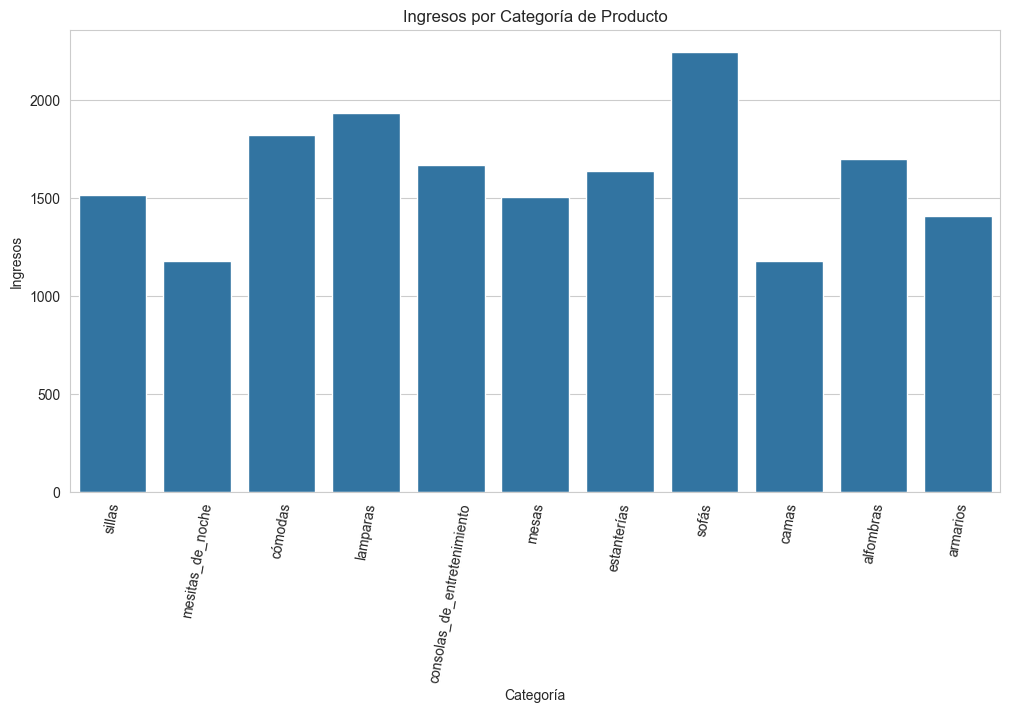

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='total_amt', data=merged_df, ci=None)
plt.title('Ingresos por Categoría de Producto')
plt.xlabel('Categoría')
plt.ylabel('Ingresos')
plt.xticks(rotation=80)
plt.show()

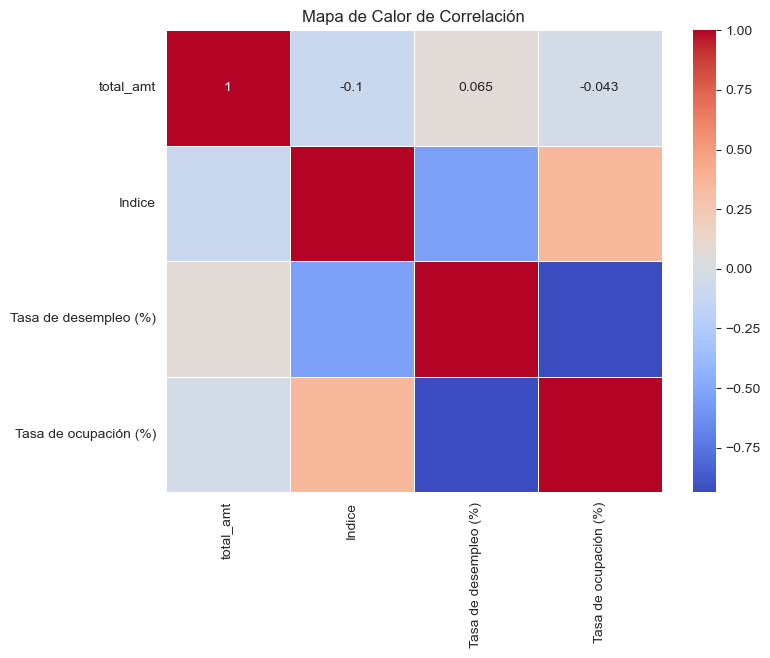

In [ ]:
# Calcular matriz de correlación
correlation_matrix = demand_df_eco[['total_amt', 'Indice', 'Tasa de desempleo (%)',  'Tasa de ocupación (%)']].corr()

# Crear mapa de calor de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de Correlación')
plt.show()

El gráfico de correlación entre los ingresos y las variables económicas indica que hay muy poca correlación entre la demanda y el IPC, tasa de desempleo y tasa de ocupación.

Ahora, vamos a descomponer la serie temporal. Las partes en las que podemos dividir una serie de tiempo son: nivel, tendencia, estacionalidad y ruido, todas las series contienen nivel y ruido pero la estacionalidad y la tendencia no siempre están presentes. En la tendencia se puede observar una pendiente creciente o decreciente en la serie temporal.

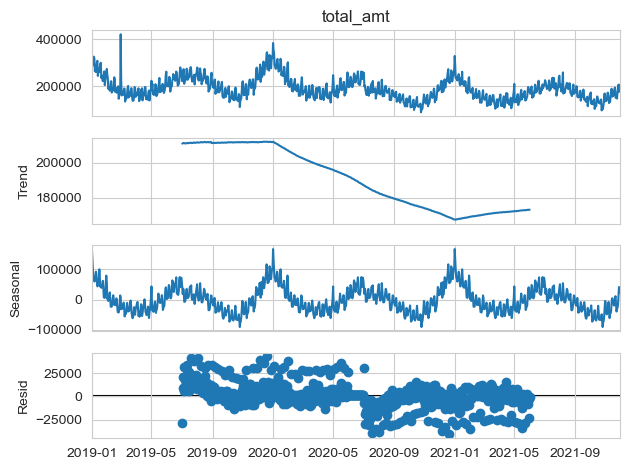

In [ ]:
demanda = daily_demand.set_index("date")
descomposicion = seasonal_decompose(demanda["total_amt"], model="additive", period=365)

descomposicion.plot()
plt.show()

En el gráfico se puede observar una tendencia decreciente en los ingresos a lo largo del tiempo. Además, se observa un patrón estacionario en los datos.

## Modelado

Para crear los modelos que predigan la demanda, primero se deben preparar los datos para que no haya error en los modelos.

- Codificación de variables categóricas: Convierte las variables categóricas como categoria y tamaño en variables numéricas utilizando técnicas como one-hot encoding.

- Escalado de características numéricas: las características numéricas como Indice, Tasa de ocupación (%), y Tasa de desempleo (%), se le aplican una normalización para asegurarse de que todas las características estén en la misma escala.

In [ ]:
def preprocess_data_for_modeling(data: pd.DataFrame,
                                 cat_cols: list,
                                 num_cols: list
                                 ) -> pd.DataFrame:
    """
    Preprocesa los datos para su uso en modelos de machine learning.

    Parámetros:
        data (pd.DataFrame): DataFrame de Pandas que contiene los datos a preprocesar.
        cat_cols (list): Lista de nombres de columnas que contienen variables categóricas.
        num_cols (list): Lista de nombres de columnas que contienen variables numéricas.

    Devuelve:
        pd.DataFrame: DataFrame de Pandas preprocesado con variables categóricas convertidas a variables dummy
                      y variables numéricas normalizadas.
    """
    # Convertir categorías a variables dummy
    one_hot_encoded_data = pd.get_dummies(data, columns=cat_cols)
    scaler = StandardScaler()
    # Normalizar las variables numéricas
    one_hot_encoded_data[num_cols] = scaler.fit_transform(one_hot_encoded_data[num_cols])

    return one_hot_encoded_data

In [ ]:
# Definir las columnas categóricas a convertir y las numéricas
cat_cols = ["category", "size", 'product_id']
num_cols = ["Indice", "Tasa de ocupación (%)", "Tasa de desempleo (%)"]
preprocessed_data = preprocess_data_for_modeling(merged_df, cat_cols, num_cols)

### División del conjunto de datos en entrenamiento y prueba

Para esto vamos a usar al rededor del 70% de los datos para el entrenamiento, el 20% para validación y el 10% para pruebas.

In [ ]:
# Fecha de división para entrenamiento y prueba
fecha_entrenamiento = pd.to_datetime("2021-02-01")
fecha_prediccion = pd.to_datetime("2021-09-01")  # Nueva fecha para la predicción

# Filtrar datos para entrenamiento
df_train = preprocessed_data[preprocessed_data["date"] < fecha_entrenamiento]

# Filtrar datos para prueba
df_test = preprocessed_data[(preprocessed_data["date"] >= fecha_entrenamiento) & (preprocessed_data["date"] < fecha_prediccion)]
testing_dates = df_test["date"]

# Filtrar datos para predicción
df_pred = preprocessed_data[preprocessed_data["date"] >= fecha_prediccion]

# Definir variables independientes y la variable objetivo para el entrenamiento
X_train = df_train.drop(['date', 'total_amt'], axis=1)
y_train = df_train['total_amt']

# Definir variables independientes y la variable objetivo para la prueba
X_test = df_test.drop(['date', 'total_amt'], axis=1)
y_test = df_test['total_amt']

# Definir variables independientes y la variable objetivo para la predicción
X_pred = df_pred.drop(['date', 'total_amt'], axis=1)



In [ ]:
# Calcular el porcentaje de fechas en el conjunto de entrenamiento
train_date_percentage = len(df_train) / len(preprocessed_data) * 100

# Calcular el porcentaje de fechas en el conjunto de prueba
test_date_percentage = len(df_test) / len(preprocessed_data) * 100

# Calcular el porcentaje de fechas en el conjunto de predicción
pred_date_percentage = len(df_pred) / len(preprocessed_data) * 100

# Imprimir los porcentajes
print(f"Porcentaje de fechas en el conjunto de entrenamiento: {train_date_percentage:.2f}%")
print(f"Porcentaje de fechas en el conjunto de prueba: {test_date_percentage:.2f}%")
print(f"Porcentaje de fechas en el conjunto de predicción: {pred_date_percentage:.2f}%")

Porcentaje de fechas en el conjunto de entrenamiento: 71.95%
Porcentaje de fechas en el conjunto de prueba: 19.43%
Porcentaje de fechas en el conjunto de predicción: 8.62%


## Modelos entrenados

Vamos a utilizar LightGBM y XGBoost para predecir los ingresos, ya que se busca anticipar las necesidades de inventario y proyección financiera y el uso de algoritmos como LightGBM y XGBoost resulta altamente beneficioso. Estos algoritmos destacan por su eficiencia en el manejo de grandes conjuntos de datos, lo cual es común en este tipo de problemas que involucran múltiples variables como características del producto, datos temporales y económicos. Además, su capacidad para manejar automáticamente características complejas, detectar interacciones entre variables y proporcionar información sobre la importancia de las características, permite una interpretación más profunda de los factores que influyen en la demanda.

Se utilizará la librería Optuna para encontrar los mejores parámetros minimizando el **RMSE** en cada modelo.

In [ ]:
def train_model(trial: Trial,
                X_train: np.ndarray,
                y_train: np.ndarray,
                X_test: np.ndarray,
                y_test: np.ndarray,
                model_type: str
                ) -> Any:
    """
    Entrena un modelo de aprendizaje automático con hiperparámetros optimizados utilizando Optuna.

    Argumentos:
        trial: Objeto de prueba de Optuna.
        X_train: Características de entrenamiento (matriz NumPy).
        X_test: Características de prueba (matriz NumPy).
        model_type: Cadena que especifica el tipo de modelo ('xgboost', 'random_forest', 'svm', 'lightgbm').

    Devuelve:
        Objeto que contiene el modelo entrenado (el tipo depende de model_type).
    """

    model_configs = {
        'xgboost': {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
            'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e3),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'eval_metric': 'rmse',
            'use_label_encoder': False
        },
        'lightgbm': {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
            'metric': 'rmse'
        }
    }

    if model_type not in model_configs:
        raise ValueError(f"Invalid model type: {model_type}")
    model_params = model_configs[model_type]

    # Crear y entrenar el modelo
    if model_type == 'xgboost':
        model = xgb.XGBRegressor(**model_params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    elif model_type == 'lightgbm':
        model = lgb.LGBMRegressor(**model_params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    else:
        raise ValueError(f"Invalid model type: {model_type}")
    return model

In [ ]:
def evaluate_model(model: Any,
                   X_test: np.ndarray,
                   y_test: np.ndarray,
                   testing_dates
                   ) -> float:
    """
    Evalúa un modelo entrenado utilizando el RMSE (Error Cuadrático Medio).

    Argumentos:
        model: Modelo entrenado.
        X_test: Conjunto de características de prueba.
        y_test: Etiquetas de prueba.

    Devuelve:
        float: Error Cuadrático Medio (RMSE) de la evaluación del modelo.
    """

    y_pred = model.predict(X_test)

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    fig = plot_predictions(testing_dates, y_test, y_pred)

    return rmse, fig

def plot_predictions(testing_dates: list, y_test: list, y_pred: list) -> plt.Figure:
    """
    Grafica las predicciones frente a los valores reales a lo largo de las fechas de prueba.

    Parámetros:
        testing_dates (list): Lista de fechas de prueba.
        y_test (list): Lista de valores reales de prueba.
        y_pred (list): Lista de valores predichos.

    Devuelve:
        plt.Figure: Figura del gráfico de líneas que muestra las predicciones y los valores reales.
    """
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": y_pred})

    # Agrupar por fecha y calcular la media de las predicciones
    df_grouped = df_test.groupby("date").mean().reset_index()

    # Configurar el estilo del gráfico
    sns.set_theme(style="whitegrid")

    # Crear el gráfico de líneas
    figure, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(data=df_grouped, x="date", y="actual", label="Actual", ax=ax)
    sns.lineplot(data=df_grouped, x="date", y="prediction", label="Prediction", ax=ax)
    ax.legend(["Actual", "Prediction"])
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.set_title("Actual vs Prediction")
    ax.tick_params(axis='x', rotation=45)  # Ajustar la rotación de los ticks del eje x
    plt.tight_layout()
    plt.close(figure)

    return figure

In [ ]:

def objective(trial: Trial,
              X_train: np.ndarray,
              y_train: np.ndarray,
              X_test: np.ndarray,
              y_test: np.ndarray,
              model_type: str,
              testing_dates
              ) -> float:
    """
    Función objetivo para la optimización de hiperparámetros con Optuna.

    Argumentos:
        trial: Objeto de prueba de Optuna.
        X_train: Características de entrenamiento.
        y_train: Etiquetas de entrenamiento.
        X_test: Características de prueba.
        y_test: Etiquetas de prueba.
        model_type: Cadena de tipo de modelo (por ejemplo, 'xgboost').

    Devuelve:
        float: Valor del puntaje F1 del modelo.
    """

    trained_model = train_model(trial, X_train, y_train, X_test, y_test, model_type)
    rmse, fig = evaluate_model(trained_model, X_test, y_test, testing_dates)

    # Registro de métricas e hiperparámetros con MLflow
    with mlflow.start_run(nested=True):
        mlflow.log_params(trial.params)
        mlflow.log_metrics({'rmse': rmse})
        mlflow.sklearn.log_model(trained_model, f'{model_type}')
        mlflow.log_figure(fig, "prediction.png")

        # Registrar rutas de artefactos para su posterior recuperación
        prediction_path = Path(mlflow.get_artifact_uri()) / "prediction.png"
        trial.set_user_attr("prediction_path", str(prediction_path))


        # Ruta del modelo de registro en artefactos
        model_path = Path(mlflow.get_artifact_uri()) / f"{model_type}/model.pkl"
        trial.set_user_attr("model_path", str(model_path))

    return rmse


In [ ]:
def optimize_and_visualize_models(objective: Trial,
                                  X_train: np.ndarray,
                                  y_train: np.ndarray,
                                  X_test: np.ndarray,
                                  y_test: np.ndarray,
                                  model_types,
                                  testing_dates,
                                  n_trials:int =20
                                  ) -> None:
    """
    Realiza la optimización de hiperparámetros para varios tipos de modelos,
    almacena los mejores modelos y muestra visualizaciones con los mejores puntajes F1.

    Argumentos:
        objective: Función que toma un objeto de prueba y datos de entrenamiento/prueba,
                                entrena un modelo y devuelve el puntaje F1.
        X_train: Características de entrenamiento.
        y_train: Etiquetas de entrenamiento.
        X_test: Características de prueba.
        y_test: Etiquetas de prueba.
        model_types: Lista de tipos de modelo a considerar (por ejemplo, 'xgboost', 'svm').
        n_trials: Número de pruebas para la optimización de cada tipo de modelo. Por defecto es 10.
    """

    best_models = {}

    # Optimización y almacene las mejores pruebas para cada tipo de modelo.
    for model_type in model_types:
        study = create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, model_type, testing_dates), n_trials=n_trials)
        best_trial = study.best_trial
        best_models[model_type] = best_trial

    # Iterar sobre los mejores modelos y mostrar visualizaciones
    for model_type, best_trial in best_models.items():
        best_rmse = best_trial.value
        print(f"Best RMSE {model_type} model: {best_rmse}")

        prediction_path = best_trial.user_attrs.get("prediction_path")[6:]
        print(prediction_path)
        prediction_plot = plt.imread(Path(prediction_path))
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.imshow(prediction_plot)
        ax.set_title(f"Real vs. Predict - {model_type} (Best Model)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")

        plt.show()

    return best_models

[I 2024-04-25 09:39:42,773] A new study created in memory with name: no-name-c5dd53e1-f373-4a49-abe6-69551e517106
[I 2024-04-25 09:39:56,601] Trial 0 finished with value: 883.849517274852 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.0020851054969915662, 'gamma': 195.05494487049276, 'subsample': 0.9267839085461207, 'colsample_bytree': 0.5320516077952279, 'num_leaves': 91, 'min_data_in_leaf': 39}. Best is trial 0 with value: 883.849517274852.
[I 2024-04-25 09:40:18,533] Trial 1 finished with value: 818.1259009652845 and parameters: {'n_estimators': 207, 'max_depth': 7, 'learning_rate': 0.004276255751635547, 'gamma': 1.6664704459197843, 'subsample': 0.9314589101698684, 'colsample_bytree': 0.8401176333914573, 'num_leaves': 18, 'min_data_in_leaf': 44}. Best is trial 1 with value: 818.1259009652845.
[I 2024-04-25 09:40:48,540] Trial 2 finished with value: 532.0821585198087 and parameters: {'n_estimators': 357, 'max_depth': 3, 'learning_rate': 0.058517379534043484,

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_sample

[I 2024-04-25 09:56:10,035] Trial 0 finished with value: 855.0344487455372 and parameters: {'n_estimators': 314, 'max_depth': 9, 'learning_rate': 0.001326694623291296, 'gamma': 0.03289333235107494, 'subsample': 0.9246461048927838, 'colsample_bytree': 0.78833243716941, 'num_leaves': 27, 'min_data_in_leaf': 23}. Best is trial 0 with value: 855.0344487455372.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:56:15,664] Trial 1 finished with value: 859.4505484155691 and parameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.010339697374348327, 'gamma': 35.988301521858524, 'subsample': 0.5176660722166719, 'colsample_bytree': 0.8806577918778766, 'num_leaves': 60, 'min_data_in_leaf': 48}. Best is trial 0 with value: 855.0344487455372.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:56:23,266] Trial 2 finished with value: 446.0869311591376 and parameters: {'n_estimators': 270, 'max_depth': 9, 'learning_rate': 0.05120547067919853, 'gamma': 0.0022098365426357226, 'subsample': 0.951882153666041, 'colsample_bytree': 0.9194206105120887, 'num_leaves': 51, 'min_data_in_leaf': 50}. Best is trial 2 with value: 446.0869311591376.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_sample

[I 2024-04-25 09:56:29,813] Trial 3 finished with value: 871.5423452852312 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.001779557366609728, 'gamma': 0.08249403155322972, 'subsample': 0.89542810065071, 'colsample_bytree': 0.9636639688651552, 'num_leaves': 53, 'min_data_in_leaf': 23}. Best is trial 2 with value: 446.0869311591376.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:56:36,045] Trial 4 finished with value: 859.0669547632455 and parameters: {'n_estimators': 272, 'max_depth': 3, 'learning_rate': 0.004033539765636831, 'gamma': 0.18148147658322794, 'subsample': 0.9960829501942141, 'colsample_bytree': 0.9914446246214959, 'num_leaves': 74, 'min_data_in_leaf': 45}. Best is trial 2 with value: 446.0869311591376.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_sample

[I 2024-04-25 09:56:44,343] Trial 5 finished with value: 751.1816456281911 and parameters: {'n_estimators': 375, 'max_depth': 10, 'learning_rate': 0.003412421888015148, 'gamma': 0.018881099158758716, 'subsample': 0.727228088048101, 'colsample_bytree': 0.6787629996356643, 'num_leaves': 64, 'min_data_in_leaf': 42}. Best is trial 2 with value: 446.0869311591376.


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:56:52,724] Trial 6 finished with value: 679.2290178364403 and parameters: {'n_estimators': 513, 'max_depth': 6, 'learning_rate': 0.007171347451751475, 'gamma': 27.200074645681315, 'subsample': 0.8129666379152756, 'colsample_bytree': 0.8090107379442755, 'num_leaves': 71, 'min_data_in_leaf': 12}. Best is trial 2 with value: 446.0869311591376.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:57:00,042] Trial 7 finished with value: 739.5130111284591 and parameters: {'n_estimators': 289, 'max_depth': 7, 'learning_rate': 0.00689186969583851, 'gamma': 0.18218968521472914, 'subsample': 0.8131183683749683, 'colsample_bytree': 0.9769026442381372, 'num_leaves': 96, 'min_data_in_leaf': 19}. Best is trial 2 with value: 446.0869311591376.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:57:09,106] Trial 8 finished with value: 704.1937078938172 and parameters: {'n_estimators': 528, 'max_depth': 7, 'learning_rate': 0.004969062766683018, 'gamma': 0.0018030426033416515, 'subsample': 0.9608001448450049, 'colsample_bytree': 0.5281499458114325, 'num_leaves': 82, 'min_data_in_leaf': 21}. Best is trial 2 with value: 446.0869311591376.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:57:14,986] Trial 9 finished with value: 556.2891903292121 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.09755730647013708, 'gamma': 0.003301812564401326, 'subsample': 0.5160322074926187, 'colsample_bytree': 0.9535382229392952, 'num_leaves': 27, 'min_data_in_leaf': 44}. Best is trial 2 with value: 446.0869311591376.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_sample

[I 2024-04-25 09:57:26,720] Trial 10 finished with value: 382.1030056007492 and parameters: {'n_estimators': 931, 'max_depth': 10, 'learning_rate': 0.056181741799037246, 'gamma': 945.0406642973006, 'subsample': 0.6955110035319672, 'colsample_bytree': 0.6806589838179209, 'num_leaves': 45, 'min_data_in_leaf': 36}. Best is trial 10 with value: 382.1030056007492.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:57:38,681] Trial 11 finished with value: 376.35561652517066 and parameters: {'n_estimators': 978, 'max_depth': 9, 'learning_rate': 0.05584235944505766, 'gamma': 2.771091418792228, 'subsample': 0.6621888996180585, 'colsample_bytree': 0.6392091768263927, 'num_leaves': 43, 'min_data_in_leaf': 34}. Best is trial 11 with value: 376.35561652517066.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_sample

[I 2024-04-25 09:57:50,979] Trial 12 finished with value: 415.71313467783426 and parameters: {'n_estimators': 967, 'max_depth': 10, 'learning_rate': 0.02182080211861507, 'gamma': 568.4842352529455, 'subsample': 0.6377085107261192, 'colsample_bytree': 0.6559713091327544, 'num_leaves': 42, 'min_data_in_leaf': 35}. Best is trial 11 with value: 376.35561652517066.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_sample

[I 2024-04-25 09:58:01,527] Trial 13 finished with value: 414.5867862383481 and parameters: {'n_estimators': 990, 'max_depth': 9, 'learning_rate': 0.030215426736572855, 'gamma': 8.15464948870407, 'subsample': 0.6575517443930995, 'colsample_bytree': 0.5853215731077845, 'num_leaves': 13, 'min_data_in_leaf': 33}. Best is trial 11 with value: 376.35561652517066.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:58:12,139] Trial 14 finished with value: 368.54160958901224 and parameters: {'n_estimators': 809, 'max_depth': 8, 'learning_rate': 0.09610428586401025, 'gamma': 963.404263795945, 'subsample': 0.618042581404913, 'colsample_bytree': 0.695131716448983, 'num_leaves': 37, 'min_data_in_leaf': 39}. Best is trial 14 with value: 368.54160958901224.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_sample

[I 2024-04-25 09:58:22,241] Trial 15 finished with value: 354.3959703319584 and parameters: {'n_estimators': 805, 'max_depth': 8, 'learning_rate': 0.09785833248303984, 'gamma': 4.265998006948447, 'subsample': 0.5813446610235182, 'colsample_bytree': 0.61675714869172, 'num_leaves': 35, 'min_data_in_leaf': 29}. Best is trial 15 with value: 354.3959703319584.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_sample

[I 2024-04-25 09:58:32,007] Trial 16 finished with value: 463.13461867645594 and parameters: {'n_estimators': 742, 'max_depth': 8, 'learning_rate': 0.017473611598009007, 'gamma': 125.7459637418659, 'subsample': 0.5849654710814846, 'colsample_bytree': 0.7390854318582878, 'num_leaves': 30, 'min_data_in_leaf': 28}. Best is trial 15 with value: 354.3959703319584.


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_sample

[I 2024-04-25 09:58:40,421] Trial 17 finished with value: 388.039759433785 and parameters: {'n_estimators': 775, 'max_depth': 5, 'learning_rate': 0.07223939572804859, 'gamma': 1.5393112088229384, 'subsample': 0.5847777795380245, 'colsample_bytree': 0.5007632451996148, 'num_leaves': 10, 'min_data_in_leaf': 29}. Best is trial 15 with value: 354.3959703319584.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2024-04-25 09:58:50,789] Trial 18 finished with value: 419.2032447770258 and parameters: {'n_estimators': 750, 'max_depth': 8, 'learning_rate': 0.03282894077493862, 'gamma': 256.64948455982767, 'subsample': 0.5845460714950703, 'colsample_bytree': 0.5899201328822544, 'num_leaves': 35, 'min_data_in_leaf': 40}. Best is trial 15 with value: 354.3959703319584.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 90982, number of used features: 159
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1673.886084
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_sample

[I 2024-04-25 09:59:00,648] Trial 19 finished with value: 378.8621002468319 and parameters: {'n_estimators': 637, 'max_depth': 8, 'learning_rate': 0.09520292458293027, 'gamma': 54.52218943232903, 'subsample': 0.7806306790669773, 'colsample_bytree': 0.7349697424028739, 'num_leaves': 22, 'min_data_in_leaf': 38}. Best is trial 15 with value: 354.3959703319584.


Best RMSE xgboost model: 353.4840258870933
c:\Users\Sara\Documents\amount_prediction\notebooks\mlruns\0\c20ec2bf24404ea49fcbfc5dba4c8f15\artifacts\prediction.png


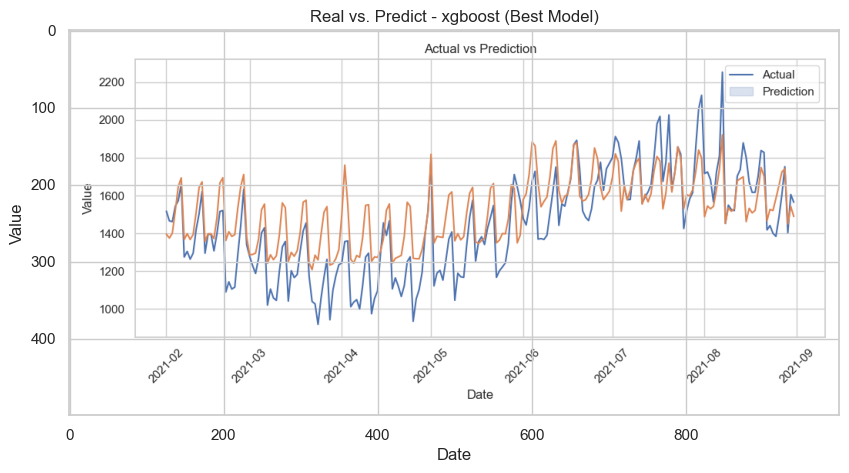

Best RMSE lightgbm model: 354.3959703319584
c:\Users\Sara\Documents\amount_prediction\notebooks\mlruns\0\f6b44f68704843809479e9d8d9968523\artifacts\prediction.png


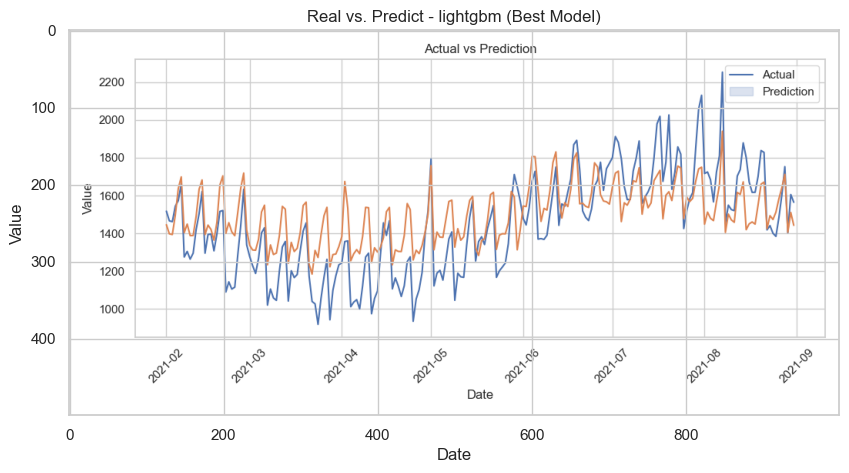

In [ ]:
# Definir la lista de modelos a considerar
model_types = ['xgboost','lightgbm']
best_models = optimize_and_visualize_models(objective, X_train, y_train, X_test, y_test, model_types, testing_dates)

## Mejor modelo

El mejor modelo elegido es XGBoost debido a que presenta un RMSE ligeramente más bajo que el mejor LightGBM (353). Un RMSE (Root Mean Square Error) de 353 indica que, en promedio, las predicciones del modelo tienen un error de aproximadamente 353 dólares en la estimación de los ingresos diarios por producto.

## Recomendaciones

Para mejorar el rendimiento del modelo de predicción de ingresos, se pueden aplicar varias estrategias.

- En primer lugar, se sugiere realizar una exploración más detallada de las características utilizadas, considerando la creación de nuevas características derivadas y la eliminación de aquellas que no contribuyan significativamente a la predicción.

- Continuar con la optimización de hiperparámetros utilizando técnicas avanzadas como la búsqueda bayesiana de hiperparámetros para encontrar la combinación óptima que mejore el rendimiento.
-  Probar con otros modelos como LSTM, modelos ARIMA y SARIMA y modelos de emsamble como combinar XGBoost + Lightgbm.

## Predicción con el mejor modelo con datos nuevos

In [ ]:
# Recuperar ruta de mejor modelo guardado con MLFlow
xgboost_model_info = best_models['xgboost']
model_path = xgboost_model_info.user_attrs.get("model_path")[6:]
# Loag model
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [ ]:
pred_dates = df_pred["date"]
real_total_amt = df_pred["total_amt"]

prediction = model.predict(X_pred)
# Crear un DataFrame con las fechas de predicción y las predicciones
prediction_df = pd.DataFrame({'date': pred_dates,  'total_amt_real': real_total_amt, 'total_amt_pred': prediction})

# Imprimir el DataFrame resultante
print(prediction_df)

             date  total_amt_real  total_amt_pred
926    2021-09-01         3013.20     2379.752686
927    2021-09-02         2372.40     2390.801270
928    2021-09-03         2236.68     2446.545166
929    2021-09-05         2353.62     2122.163330
930    2021-09-06         2001.98     2243.878418
...           ...             ...             ...
126455 2021-11-26         4382.15     3725.468750
126456 2021-11-27         4313.75     3151.544189
126457 2021-11-28         2918.40     2400.027100
126458 2021-11-29         3632.88     2755.766602
126459 2021-11-30         3515.82     2748.711182

[10906 rows x 3 columns]


In [ ]:
rmse_pred = np.sqrt(mean_squared_error(real_total_amt, prediction))
print(rmse_pred)

368.0722387690027
